# Final Processing of GAMA-09 Blind source catalogue

![HELP LOGO](https://avatars1.githubusercontent.com/u/7880370?s=100&v=4>)


The final processing stage requires:
1. Quick validation of blind catalogues and Bayesian Pvalue maps
2. Skewness level
3. Adding flag to catalogue
4. Merging MF catalogue with XID+ flux densities

In [1]:
import seaborn as sns
from astropy.table import Table,hstack
%matplotlib inline
import numpy as np
import pylab as plt

from astropy import units as u
from astropy.table import Column

import herschelhelp_internal
from herschelhelp_internal.utils import gen_help_id
import numpy.core.defchararray as np_f


## Read tables

In [2]:
cat=Table.read('./data/dmu22_XID+SPIRE_GAMA-09_BLIND.fits')
cat['RA'].unit=u.deg
cat['Dec'].unit=u.deg

In [3]:
cat[0:10]

HELP_ID,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500
,deg,deg,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
915,138.597893586,-1.88173224228,87.737,91.6126,83.5257,26.7445,30.9497,22.5869,4.50467,8.44942,1.76909,-0.00268233,-0.00346683,-0.00223681,0.00167939,0.0023008,0.00334509,1.00047,0.999044,0.99911,2000.0,2000.0,2000.0,0.0,0.0,0.0
8531,138.539657957,-1.83689639467,45.0556,49.0933,40.9651,33.581,37.5221,29.5386,29.5537,34.2133,24.9732,-0.00268233,-0.00346683,-0.00223681,0.00167939,0.0023008,0.00334509,0.999109,0.998431,0.999114,2000.0,2000.0,2000.0,0.0,0.0,0.0
28704,138.521634688,-1.81058272984,32.0918,35.9082,28.0898,34.3578,38.2489,30.2031,36.588,41.0571,32.1382,-0.00268233,-0.00346683,-0.00223681,0.00167939,0.0023008,0.00334509,0.998899,0.998767,1.00031,2000.0,2000.0,2000.0,0.0,0.0,0.0
56589,138.579307348,-1.89478044426,15.9224,20.3932,11.447,7.75978,12.3659,3.71131,11.9675,16.7167,7.37892,-0.00268233,-0.00346683,-0.00223681,0.00167939,0.0023008,0.00334509,0.999527,0.999668,0.999306,2000.0,2000.0,2000.0,0.0,0.0,0.0
67018,138.572104752,-1.85931151155,11.5182,15.9186,7.48358,5.70763,9.66914,2.47307,4.34981,8.28356,1.53404,-0.00268233,-0.00346683,-0.00223681,0.00167939,0.0023008,0.00334509,0.99842,1.0009,0.999645,2000.0,2000.0,2000.0,0.0,0.0,0.0
87665,138.559624694,-1.85350499571,8.54958,12.5806,4.60637,1.24569,2.88706,0.337092,1.16278,2.88085,0.288976,-0.00268233,-0.00346683,-0.00223681,0.00167939,0.0023008,0.00334509,0.998839,0.99982,1.00093,2000.0,2000.0,2000.0,0.0,0.0,0.0
99598,138.520144015,-1.83293814567,8.89665,13.2235,4.81926,13.263,16.8557,9.68295,5.92893,8.43386,3.51118,-0.00268233,-0.00346683,-0.00223681,0.00167939,0.0023008,0.00334509,0.998592,0.998506,0.999439,2000.0,2000.0,2000.0,0.0,0.0,0.0
103055,138.591135181,-1.89494448544,3.22827,6.68331,1.00327,8.94075,12.9367,4.81768,2.089,4.98246,0.614548,-0.00268233,-0.00346683,-0.00223681,0.00167939,0.0023008,0.00334509,0.998796,1.00053,0.999669,2000.0,2000.0,2000.0,0.0,0.001,0.0


## Look at Symmetry of PDFs to determine depth level of catalogue

/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


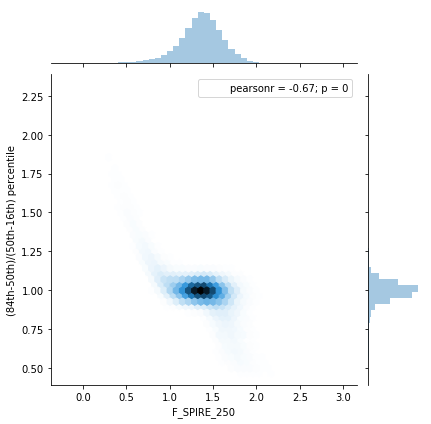

In [4]:
skew=(cat['FErr_SPIRE_250_u']-cat['F_SPIRE_250'])/(cat['F_SPIRE_250']-cat['FErr_SPIRE_250_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_250']),y=skew, kind='hex')

For 250 $\mathrm{\mu m}$ depth is ~ 6mJy

/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


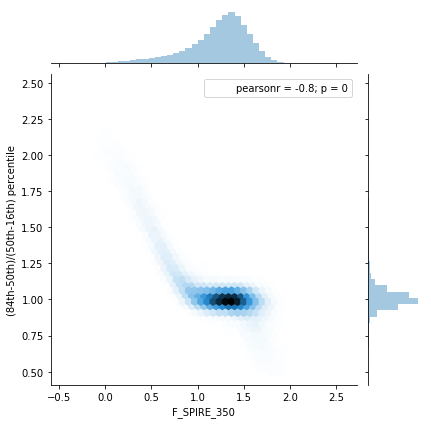

In [5]:
skew=(cat['FErr_SPIRE_350_u']-cat['F_SPIRE_350'])/(cat['F_SPIRE_350']-cat['FErr_SPIRE_350_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_350']),y=skew, kind='hex')


For 350 $\mathrm{\mu m}$ depth is ~ 6mJy

/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


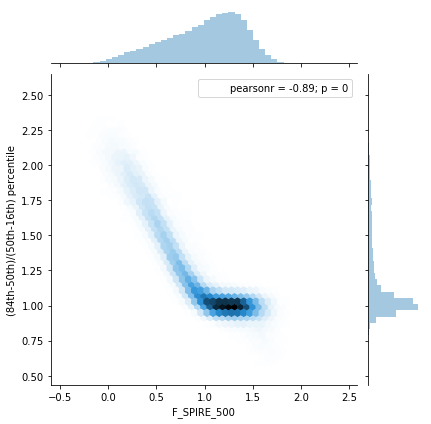

In [6]:
skew=(cat['FErr_SPIRE_500_u']-cat['F_SPIRE_500'])/(cat['F_SPIRE_500']-cat['FErr_SPIRE_500_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_500']),y=skew, kind='hex')


For 500 $\mathrm{\mu m}$ depth is ~ 6mJy

## Add flag to catalogue

In [7]:
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_250'))
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_350'))
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_500'))

In [8]:
ind_250=(cat['Pval_res_250']>0.5) | (cat['F_SPIRE_250'] < 6)
ind_350=(cat['Pval_res_350']>0.5) | (cat['F_SPIRE_350'] < 6)
ind_500=(cat['Pval_res_500']>0.5) | (cat['F_SPIRE_500'] < 6)

In [9]:
print(ind_250.sum(),ind_350.sum(),ind_500.sum(),len(cat))

5909 13952 31918 111485


In [10]:
cat['flag_spire_250'][ind_250]=True
cat['flag_spire_350'][ind_350]=True
cat['flag_spire_500'][ind_500]=True

In [11]:
# set XID+ cahtalogue back to orignal order of objects, as used in MF detection files
use = cat['HELP_ID'].astype(int) -1
use = np.argsort(use)
cat = cat[use]

In [12]:
# Reads MF table, removes duplicate RA and DEC
cat2=Table.read('./data/GAMA-09_SPIRE_all.fits')
del cat2['RA']
del cat2['Dec']
cat_all = hstack([cat,cat2])

In [13]:
# Created HELP_ID, and changes HELP to HELP_BLIND to avoid confusion with HELP-Masterlist objects
ID = gen_help_id(cat_all['RA'], cat_all['Dec'])
ID_new = [IDs.replace('HELP','HELP_BLIND') for IDs in ID]
ID_new = Column(ID_new,name="HELP_ID")
cat_all['HELP_ID'] = ID_new

In [14]:
# all flux denisties are in mJy in the final BLIND catalogues
cat_all['F_BLIND_MF_SPIRE_250'].unit = 'mJy'
cat_all['F_BLIND_MF_SPIRE_250'] = 1000*cat_all['F_BLIND_MF_SPIRE_250']
cat_all['FErr_BLIND_MF_SPIRE_250'].unit = 'mJy'
cat_all['FErr_BLIND_MF_SPIRE_250'] = 1000*cat_all['FErr_BLIND_MF_SPIRE_250']

cat_all['F_BLIND_MF_SPIRE_350'].unit = 'mJy'
cat_all['F_BLIND_MF_SPIRE_350'] = 1000*cat_all['F_BLIND_MF_SPIRE_350']
cat_all['FErr_BLIND_MF_SPIRE_350'].unit = 'mJy'
cat_all['FErr_BLIND_MF_SPIRE_350'] = 1000*cat_all['FErr_BLIND_MF_SPIRE_350']

cat_all['F_BLIND_MF_SPIRE_500'].unit = 'mJy'
cat_all['F_BLIND_MF_SPIRE_500'] = 1000*cat_all['F_BLIND_MF_SPIRE_500']
cat_all['FErr_BLIND_MF_SPIRE_500'].unit = 'mJy'
cat_all['FErr_BLIND_MF_SPIRE_500'] = 1000*cat_all['FErr_BLIND_MF_SPIRE_500']

cat_all['F_BLIND_pix_SPIRE'].unit = 'mJy'
cat_all['F_BLIND_pix_SPIRE'] = 1000*cat_all['F_BLIND_pix_SPIRE']
cat_all['FErr_BLIND_pix_SPIRE'].unit = 'mJy'
cat_all['FErr_BLIND_pix_SPIRE'] = 1000*cat_all['FErr_BLIND_pix_SPIRE']


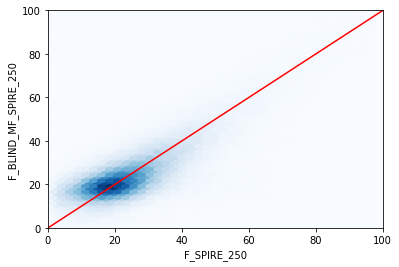

In [18]:
# XID+ flux density vs. MF flux densities
plt.hexbin(cat_all['F_SPIRE_250'],cat_all['F_BLIND_MF_SPIRE_250'], cmap=plt.cm.Blues,gridsize=(600,600))
plt.plot([0,100],[0,100], color = 'red')
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel('F_SPIRE_250')
plt.ylabel('F_BLIND_MF_SPIRE_250')
plt.show()


In [20]:
# Add field name
cat_all.add_column(Column(['GAMA-09']*len(cat_all),name='field'))


In [21]:
cat_all.write('./data/dmu22_XID+SPIRE_GAMA-09_BLIND_Matched_MF.fits', format='fits',overwrite=True)

*This is a default HELP jupyter notebook *

 ![HELP LOGO](https://avatars1.githubusercontent.com/u/7880370?s=75&v=4)

**Authors**: S. Duivenvoorden

 
For a full description of the database and how it is organised in to `dmu_products` please the top level [readme](../readme.md).
 
The Herschel Extragalactic Legacy Project, ([HELP](http://herschel.sussex.ac.uk/)), is a [European Commission Research Executive Agency](https://ec.europa.eu/info/departments/research-executive-agency_en)
funded project under the SP1-Cooperation, Collaborative project, Small or medium-scale focused research project, FP7-SPACE-2013-1 scheme, Grant Agreement
Number 607254.

[Acknowledgements](http://herschel.sussex.ac.uk/acknowledgements)